In [63]:
#dependencies
#%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd
import seaborn

In [14]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [16]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [18]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [21]:
#inspect a sample of measurement
measurement_sample = session.query(Measurement).first()
measurement_sample.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ba947f12e8>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today

prev_year = dt.date.today() - dt.timedelta(days=500)
prev_year


datetime.date(2017, 3, 24)

In [23]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

past_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > prev_year)

past_year_df = pd.read_sql_query(past_year.statement, engine, index_col = 'date')

past_year_df.head()

,prcp
date,
2017-03-25,0.0
2017-03-26,0.0
2017-03-27,0.0
2017-03-28,0.0
2017-03-29,0.0


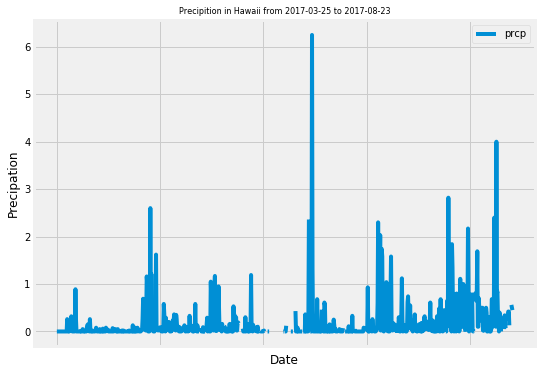

In [27]:
# Use Pandas Plotting with Matplotlib to plot the data
past_year_df.plot(figsize = (8,6))
plt.ylabel('Precipation', fontsize = 12)
plt.xlabel('Date',fontsize = 12)
plt.title("Precipition in Hawaii from %s to %s" % (past_year_df.index.min(),past_year_df.index.max()),fontsize = 8)
plt.show()

In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data
past_year_df.describe()

,prcp
count,804.000000
mean,0.164975
std,0.422235
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.250000


In [29]:
# How many stations are available in this dataset?
station_count = session.query(Station.station).group_by(Station.station).count()
station_count

9

In [30]:
# List the stations and the counts in descending order.
active_station = session.query(Station.station, Station.name, Measurement.station, func.count(Measurement.tobs)).filter(Station.station == Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
active_station

[('USC00519281', 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 'USC00517948', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [31]:
# What are the most active stations?
most_activity = active_station[0][0:2]
most_activity

('USC00519281', 'WAIHEE 837.5, HI US')

In [33]:
# Choose the station with the highest number of temperature observations.
highest_obs = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == most_activity[0], Measurement.date > prev_year).all()
len(highest_obs)

138

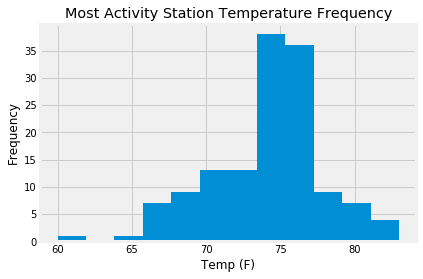

In [35]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = [x[1] for x in highest_obs]
plt.hist(temps, bins=12)
plt.xlabel("Temp (F)")
plt.ylabel("Frequency")
plt.title("Most Activity Station Temperature Frequency")
plt.show()

# Temperature Analysis

In [61]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    dates = [start_date, end_date]
    new_dates = []
    for date in dates:
        date_list = date.split("-")
        date_list[0] = str(int(date_list[0]) - 1)
        new_date = "-".join(date_list)
        new_dates.append(new_date)
    print(new_dates) 
    
    #query database for temps from those dates
    temp_data = session.query(Measurement.tobs).filter(Measurement.date >= new_dates[0], Measurement.date <= new_dates[1]).all()
    temp_list = [x for (x,) in temp_data]
    avg_temp = np.mean(temp_list)
    max_temp = max(temp_list)
    min_temp = min(temp_list)
    
    # plot a bar chart
    plt.figure(figsize=(4,6))
    plt.title("Trip Average Temp")
    plt.ylabel("Temp (F)")
    plt.bar(0.2, avg_temp, yerr = (max_temp - min_temp))
    plt.show()
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
       filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    


['2016-08-06', '2017-08-06']


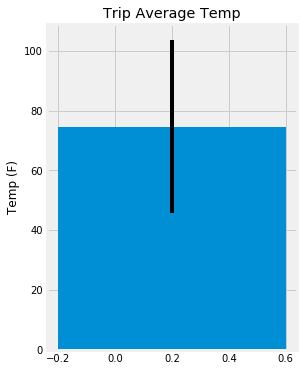

[(70.0, 78.93055555555556, 85.0)]


In [62]:
print(calc_temps('2017-08-06', '2018-08-06'))

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
